# Анализ лояльности пользователей Яндекс Афиши

- Автор:Воронина Мария Сергеевна
- Дата 08.02.2026

## Цели и задачи

**Цель:** В этом исследовательском проекте нужно нужно помочь команде маркетинга лучше понять поведение пользователей. Для этого провёдем анализ данных, чтобы выяснить, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно

**Задачи:**

1. Загрузить данные и познакомиться с их содержимым.
2. Провести предобработку данных.
3. Создать профиль пользователя.
4. Провести исследовательский анализ данных:
   - Исследовать признаки первого заказа и их связи с возвращением на платформу.
   - Исследовать поведение пользователей через показатели выручки и состава заказа.
   - Исследовать временные характеристики первого заказа и их влияния на повторные покупки.
   - Провести корреляционный анализ количества покупок и признаков пользователя.
5. Сформулировать выводы и рекомендации по проведённому анализу.
6. Опубликовать проект в Git.

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


Загрузим библитеки и подключимся к базе данных. Будем использовать `pandas`, `SQLAlchemy` и библиотеки визуализации данных `matplotlib` и `seaborn`, а также `phik` для построения матрицы корреляции.


In [1]:
# Устанавливаем библиотеку SQLAlchemy для подключения к базе данных
!pip install sqlalchemy

In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
from sqlalchemy import create_engine

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
!pip install phik
from phik import phik_matrix

In [3]:
# Подключаем базу данных
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [4]:
# Формируем строку для подключения с помощью метода format()
connection_string = 'postgresql://{user}:{pwd}@{host}:{port}/{db}?sslmode=require'.format(
    user=db_config['user'],
    pwd=db_config['pwd'],
    host=db_config['host'],
    port=db_config['port'],
    db=db_config['db'],
)

In [5]:
# Cоздаём соединение, для этого передаём строку с данными функции create_engine()
engine = create_engine(connection_string) 

In [6]:
# Извлекаем результаты SQL-запроса
query = '''
SELECT user_id,
      device_type_canonical,
      order_id,
      created_dt_msk as order_dt,
      created_ts_msk as order_ts,
      currency_code,
      revenue,
      tickets_count,
      (created_dt_msk::date - lAG(created_dt_msk :: date) OVER (PARTITION BY user_id ORDER BY created_dt_msk)) AS days_since_prev,
      event_id,
      event_name_code AS event_name,
      event_type_main, 
      service_name,
      region_name,
      city_name
FROM afisha.purchases AS p
JOIN afisha.events AS e USING(event_id)
JOIN afisha.city AS c USING(city_id)
JOIN afisha.regions AS r USING(region_id)
ORDER BY user_id
'''

In [7]:
# Записываем результаты SQL-запроса в датафрейм с помощью метода pd.read_sql_query()
df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

Познакомимся с данными из датафрейма `df`- выведем первые строки методом head(), а информацию о датафрейме методом info():

In [78]:
# Используем метода head() для вывода первых строк датафрейма
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
286678,fd4d47438ebb946,mobile,7565637,2024-06-01,2024-06-01 00:00:42,rub,1083.15,4,0.0,131671,f4431442-3d97-452d-a6d6-eadf6bd34378,театр,Прачечная,Каменевский регион,Глиногорск,1083.15
286676,fd4d47438ebb946,mobile,7565521,2024-06-01,2024-06-01 00:01:30,rub,812.36,3,0.0,131671,f4431442-3d97-452d-a6d6-eadf6bd34378,театр,Прачечная,Каменевский регион,Глиногорск,812.36
119417,57ef0a1905ac488,mobile,6670842,2024-06-01,2024-06-01 00:01:58,rub,2091.31,4,NaN,375861,ba89f19f-e73c-4d74-ab35-b9c023bb4de6,театр,Билеты в руки,Лесодальний край,Родниковец,2091.31
286677,fd4d47438ebb946,mobile,7565550,2024-06-01,2024-06-01 00:03:13,rub,812.36,3,0.0,131671,f4431442-3d97-452d-a6d6-eadf6bd34378,театр,Прачечная,Каменевский регион,Глиногорск,812.36
265839,e73089d7d016cd8,mobile,5502055,2024-06-01,2024-06-01 00:03:34,rub,181.39,2,0.0,211846,20165b73-7202-48df-a5e3-fd8cd1a70554,театр,Прачечная,Широковская область,Радужнополье,181.39


In [9]:
# Используем метод info() для вывода информации о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292034 entries, 0 to 292033
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                292034 non-null  object        
 1   device_type_canonical  292034 non-null  object        
 2   order_id               292034 non-null  int64         
 3   order_dt               292034 non-null  datetime64[ns]
 4   order_ts               292034 non-null  datetime64[ns]
 5   currency_code          292034 non-null  object        
 6   revenue                292034 non-null  float64       
 7   tickets_count          292034 non-null  int64         
 8   days_since_prev        270034 non-null  float64       
 9   event_id               292034 non-null  int64         
 10  event_name             292034 non-null  object        
 11  event_type_main        292034 non-null  object        
 12  service_name           292034 non-null  obje

Датафрейм содержит 290611 строк и 15 столбцов, в которых представлены данные сервиса "Яндекс Афиша".
После первичного анализа можно сделать выводы:
- Названия столбцов записаны в правильной формате и соответствуют информации, представленной в них.
- После изучения типов данных, можно сказать:
     - Столбцы `user_id`, `device_type_canonical`, `currency_code`, `event_name`, `event_type_main`, `service_name`, `region_name`, `city_name` имеют тип данных `object` и соотвествуют ему.
     - Столбцы `order_id`, `tickets_count`, `event_id` имеют тип данных `int64` и содержат информацию с целыми числами.
     - Столбцы `revenue`, `days_since_prev` имеют тип данных `float64` и хранят информацию с дробными числами.
     - Столбцы `order_dt` и `order_ts` имеют тип данных `datetime64` и соответствуют ему.
     
В столбце `tickets_count` можно понизить разрядность с `int64` до `int8` для оптимизации.
- Пропуски содержаться только в столбце `days_since_prev`.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


Приведем выручку к единой валюте - российскому рублю. Для этого объединим основной датасет с данными о курсах валют и проведем конвертацию. По завершении удалим лишние столбцы, оставив только данные в рублях.

Выгрузим данные о курсе казахстанского тенге по отношению к российскому рублю за 2024 год из датасета `final_tickets_tenge_df.csv` в датафрейм `inf_course`.

In [10]:
inf_course = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [11]:
# Выведем первые строки, чтобы проверить корректность датафрейма
inf_course.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [12]:
# Выведем информацию о датафрейме
inf_course.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Заметим, что у столбцов `order_dt` и `data` разный тип данных. Преобразуем столбец `data` в формат `datetime` для анализа.

In [13]:
inf_course['data'] = pd.to_datetime(inf_course['data'])

Объединим датафреймы:

In [14]:
df = df.merge(
    inf_course[['data', 'curs']],
    left_on='order_dt',
    right_on='data',
    how='left'
)

Создадим новый столбец `revenue_rub` ,  найдём все заказы в тенге и проведём конвертиртацию по формуле:

In [15]:
df['revenue_rub'] = df['revenue']

In [16]:
mask = df['currency_code'] == 'KZT'

df.loc[mask, 'revenue_rub'] = (
    df.loc[mask, 'revenue'] *
    df.loc[mask, 'curs'] / 100
)

Удалим лишние столбцы:

In [17]:
df = df.drop(columns='data')
df = df.drop(columns='curs')

In [18]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.41


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

#### Наличие пропусков в данных

Изучим пропущенные значения. Для этого выведем количество строк с пропусками.

In [19]:
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          22000
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

Пропуски содепжаться в столбце `days_since_prev`, потому что пользователи совершили только одну покупку.

#### Типы данных

На стадии знакомства с данными было принято решение понизить разрядность в столбце `tickets_count`:

In [20]:
# Понижаем с помощью метода astype() с int64 до int8
df['tickets_count'] = df['tickets_count'].astype('int8')

#### Поиск и обработка ошибок

Посмотрим, какие данные встречаются в столбцах с номинальными данными:

In [21]:
df['device_type_canonical'].unique()

array(['mobile', 'desktop', 'tablet', 'other', 'tv'], dtype=object)

In [22]:
df['event_type_main'].unique()

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'фильм', 'ёлки'], dtype=object)

In [23]:
df['service_name'].unique()

array(['Край билетов', 'Мой билет', 'За билетом!', 'Лови билет!',
       'Билеты без проблем', 'Облачко', 'Лучшие билеты', 'Прачечная',
       'Быстробилет', 'Дом культуры', 'Весь в билетах', 'Билеты в руки',
       'Тебе билет!', 'Show_ticket', 'Городской дом культуры', 'Яблоко',
       'Билет по телефону', 'Выступления.ру', 'Росбилет',
       'Шоу начинается!', 'Мир касс', 'Восьмёрка', 'Телебилет',
       'Crazy ticket!', 'Реестр', 'Быстрый кассир', 'КарандашРУ',
       'Радио ticket', 'Дырокол', 'Вперёд!', 'Кино билет', 'Цвет и билет',
       'Зе Бест!', 'Тех билет', 'Лимоны', 'Билеты в интернете'],
      dtype=object)

In [24]:
df['currency_code'].unique()

array(['rub', 'kzt'], dtype=object)

В столбцах `device_type_canonical`, `event_type_main`, `service_name`, `currency_code` дубликаты не были обнаружены.

Проверим распределение численных данных и наличие в них выбросов. 

Изучим основные статистики в столбце `revenue_rub`:

In [25]:
df['revenue_rub'].describe()

count    292034.000000
mean        624.833773
std        1225.695694
min         -90.760000
25%         116.790000
50%         355.340000
75%         809.460000
max       81174.540000
Name: revenue_rub, dtype: float64

Среднее значение больше медианы, так же присутствуют выбросы, так как максимальная цена(81175) - это аномально высокое значение. Для более точного анализа построим гистограмму распределения значений.

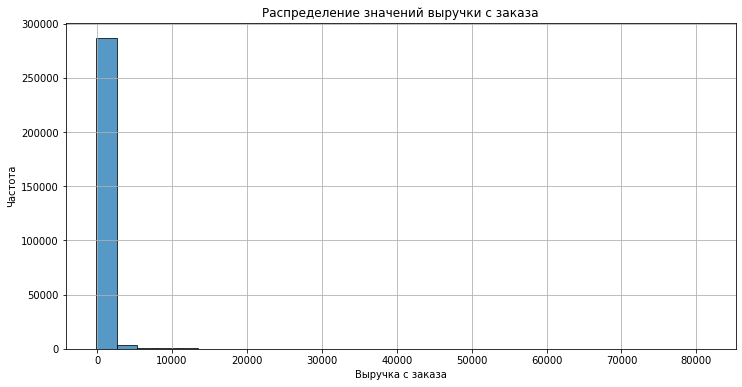

In [26]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(12, 6))

# Строим гистограмму с помощью pandas через plot(kind='hist')
df['revenue_rub'].plot(
                kind='hist', # Тип графика - гистограмма
                bins=30, # Устанавливаем количество корзин - всего 25
                alpha=0.75,
                edgecolor='black',
                rot=0, # Градус вращения подписи по оси Х
)

# Настраиваем оформление графика
plt.title('Распределение значений выручки с заказа')
plt.xlabel('Выручка с заказа')
plt.ylabel('Частота')
plt.grid()

# Выводим график
plt.show()

На основе этого графика можно сделать следующие выводы:
  - Распределение правостороннее
  - Большинство покупок сосредоточено в области малых значений
  - Присутствуют аномалии

Отфильтруем значения по 99 перцентилю:

In [27]:
df = df[df['revenue_rub'] <= df['revenue_rub'].quantile(0.99)]

Проверим корректность фильтрации:

In [28]:
df['revenue_rub'].describe()

count    289113.000000
mean        537.537405
std         563.847730
min         -90.760000
25%         114.970000
50%         347.260000
75%         793.420000
max        3997.700000
Name: revenue_rub, dtype: float64

Изучим основные статистики в столбце `tickets_count`:

In [29]:
df['tickets_count'].describe()

count    289113.000000
mean          2.749762
std           1.171001
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          57.000000
Name: tickets_count, dtype: float64

Заеметим, разница между 75% и максимальным значением очень большая. Построим ящик с усами, чтобы выявить аномалии.

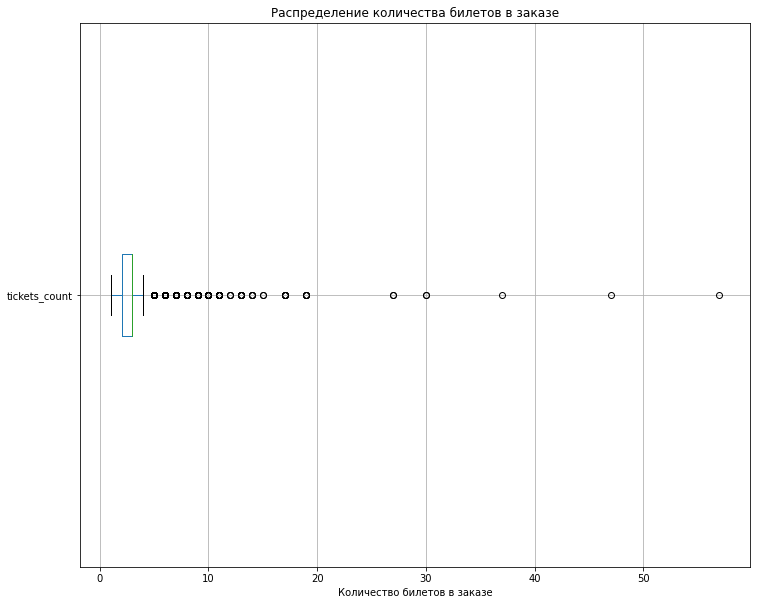

In [30]:
# Используем метод boxplot()
boxplot = df.boxplot(column='tickets_count',
                     vert=False, 
                     figsize=(12, 10))

# Добавляем заголовок и метку оси X
boxplot.set_title('Распределение количества билетов в заказе')
boxplot.set_xlabel('Количество билетов в заказе')

plt.show()

Большинство заказов сосредоточены в диапозоне 2-3 билетов, заказы больше 10 - редкие, а максимальное количество 57 билетов - аномалия. Вероятно это были групповые покупки.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


Сформируем профиль пользователя: агрегируем данные из основного датасета, создадим датафрейм `user_profile` и добавим два бинарных признака, отражающих уровень вовлеченности пользователя по количеству заказов.

Отсортируйте данные по времени совершения заказа:

In [31]:
df.sort_values('order_ts', inplace=True)

Группируем по пользователям с агрегацией ключевых метрик:

In [32]:
user_profile = df.groupby('user_id').agg({
    'order_dt' : ['min', 'max'],
    'device_type_canonical' : 'first',
    'region_name' : 'first',
    'service_name' : 'first',
    'event_type_main': 'first',
    'event_id' : 'count',
    'revenue_rub': 'mean',
    'tickets_count': 'mean',
    'days_since_prev': 'mean'
})

Переименуем столбцы:

In [33]:
user_profile.columns = [
    'first_dt',
    'last_dt',
    'first_device_type',
    'first_region',
    'first_service_name',
    'first_event_type',
    'order_count',
    'avg_revenue',
    'avg_tickets_count',
    'avg_between_days'
]

Добавление бинарных признаков лояльности:

`is_two` — совершал ли пользователь 2+ заказа

`is_five` — совершал ли пользователь 5+ заказов

In [34]:
user_profile['is_two'] = (user_profile['order_count'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['order_count'] >= 5).astype(int)

Выведем полученный датафрейм:

In [35]:
user_profile.head()

,first_dt,last_dt,first_device_type,first_region,first_service_name,first_event_type,order_count,avg_revenue,avg_tickets_count,avg_between_days,is_two,is_five
user_id,,,,,,,,,,,,
0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,1,0
000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,1,0
00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,0,0
000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

Проверим данные на аномалии, для этого изучим статистические показатели и рассчитаем:
- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Выведем общее число пользователей в выборке:

In [36]:
count_before = user_profile.shape[0]
count_before

21837

Найдём среднюю выручку с одного заказа:

In [37]:
round(user_profile['avg_revenue'].mean(), 2)

573.75

Рассчитаем долю пользователей, совершивших 2 и более заказа:

In [38]:
user_profile['is_two'].mean()

0.6179878188395842

Более половины пользователей совершили 2+ заказа.

Теперь рассчитаем долю пользователей, совершивших 5 и более заказа:

In [39]:
user_profile['is_five'].mean()

0.2908366533864542

Около 29% пользователей совершили 5+ заказов, но данные могут быть некорректны.

Выведем основные статистики по общему числу заказов:

In [40]:
user_profile['order_count'].describe()

count    21837.000000
mean        13.239593
std        122.590843
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10269.000000
Name: order_count, dtype: float64

Данные содержат критические выбросы. Отфильтруем данные по 99%, потому что выбросы искажают статистику:

In [41]:
user_profile = user_profile[user_profile['order_count'] <= user_profile['order_count'].quantile(0.95)]

Проверим корректность фильтрации:

In [42]:
user_profile['order_count'].describe()

count    20772.000000
mean         4.092962
std          5.218750
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         32.000000
Name: order_count, dtype: float64

Ещё раз рассчитаем долю пользователей, совершивших 5 и более заказа:

In [43]:
user_profile['is_five'].mean()

0.25447718082033505

Выведем основные статистики по среднему числу билетов в заказе:

In [44]:
user_profile['avg_tickets_count'].describe()

count    20772.000000
mean         2.748351
std          0.942412
min          1.000000
25%          2.000000
50%          2.750000
75%          3.166667
max         11.000000
Name: avg_tickets_count, dtype: float64

Среднее значение и медиана почти совпадают, что говорит о симметричном расспределении.

Изучим статистические показатели по среднему количеству дней между покупками:

In [45]:
user_profile['avg_between_days'].describe()

count    12481.000000
mean        17.125992
std         22.961574
min          0.000000
25%          1.000000
50%          9.500000
75%         22.250000
max        148.000000
Name: avg_between_days, dtype: float64

Распределение сильно асимметрично с большим разбросом. Есть ядро активных клиентов и длинный хвост редких покупателей.

Выведем, сколько строк осталось после фильтрации:

In [46]:
count_after = user_profile.shape[0]
count_after

20772

Рассчитаем количество отфильтрованных данных:

In [47]:
difference = count_before - count_after

In [48]:
difference / count_before

0.04877043549938178

Проанализируем статистические показатели по обновлённому датасету.

In [49]:
user_profile.describe()

,order_count,avg_revenue,avg_tickets_count,avg_between_days,is_two,is_five
count,20772.000000,20772.000000,20772.000000,12481.000000,20772.000000,20772.000000
mean,4.092962,576.707733,2.748351,17.125992,0.598402,0.254477
std,5.218750,508.487420,0.942412,22.961574,0.490233,0.435577
min,1.000000,-10.770000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,211.583750,2.000000,1.000000,0.000000,0.000000
50%,2.000000,466.708750,2.750000,9.500000,1.000000,0.000000
75%,5.000000,797.688125,3.166667,22.250000,1.000000,1.000000
max,32.000000,3891.660000,11.000000,148.000000,1.000000,1.000000


- Типичный клиент совершает 2 заказа по 467 рублей с паузой 9.5 дней.
- Лояльность средняя - 60% пользователей возвращаются, но лишь 25% становятся постоянными (5+ заказов).
- Данные реалистичны - после очистки распределения адекватны, аномалии устранены.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---







Анализ распределения пользователей по типам устройств для первого заказа:

Для каждого типа устройства подсчитаем количество пользователей и их долю от общей аудитории. Это позволит выявить наиболее популярные точки входа и понять, с каких платформ пользователи чаще начинают взаимодействие с сервисом.

In [50]:
result_device = (
    user_profile.groupby('first_device_type').agg(
    count_users=('first_device_type', 'size')).reset_index()
)
result_device['users_share'] = result_device['count_users'] / len(user_profile)
result_device.sort_values(by='count_users',ascending=False)

,first_device_type,count_users,users_share
1,mobile,17171,0.826642
0,desktop,3502,0.168592
3,tablet,98,0.004718
2,other,1,0.000048


Мобильные устройства доминируют - более 82% пользователей совершают первый заказ со смартфонов. 

Анализ распределения пользователей по типам первого мероприятия:

Для каждого типа мероприятия подсчитаем количество пользователей и их долю от общей аудитории. Это поможет выявить наиболее популярные категории для первого знакомства с сервисом и понять, какие форматы мероприятий чаще всего становятся точкой входа для новых пользователей.

In [51]:
result_event_type = (
    user_profile.groupby('first_event_type').agg(
    count_users=('first_event_type', 'size')).reset_index()
)
result_event_type['users_share'] = result_event_type['count_users'] / len(user_profile)
result_event_type.sort_values(by='count_users',ascending=False)

,first_event_type,count_users,users_share
2,концерты,9033,0.434864
1,другое,5244,0.252455
5,театр,4134,0.199018
4,стендап,1074,0.051704
3,спорт,775,0.037310
0,выставки,401,0.019305
7,ёлки,92,0.004429
6,фильм,19,0.000915


Концерты - ключевая точка входа (43,5% пользователей), за ними следуют "другие" категории (25,2%) и театр (19,9%). Фильмы и ёлки практически не используются для первого заказа.

Анализ распределения пользователей по регионам первого заказа:

Для каждого региона подсчитаем количество пользователей и их долю от общей аудитории. Это позволит выявить наиболее активные локации для первого взаимодействия с сервисом и понять, в каких регионах платформа имеет наибольшую узнаваемость.

In [52]:
result_region = (
    user_profile.groupby('first_region').agg(
    count_users=('first_region', 'size')).reset_index()
)
result_region['users_share'] = result_region['count_users'] / len(user_profile)
result_region.sort_values(by='count_users',ascending=False)

,first_region,count_users,users_share
23,Каменевский регион,6876,0.331023
60,Североярская область,3641,0.175284
77,Широковская область,1199,0.057722
45,Озернинский край,669,0.032207
41,Малиновоярский округ,530,0.025515
...,...,...,...
17,Залесский край,2,0.000096
5,Верхозёрский край,1,0.000048
56,Светолесский край,1,0.000048
66,Сосноводолинская область,1,0.000048


Каменевский регион и Североярская область формируют ядро аудитории - на них приходится более 50% всех первых заказов.

Распределение по регионам сильно сконцентрировано: первые 3 региона охватывают 56% пользователей, а большинство остальных регионов представлены единичными случаями.

Анализ распределения пользователей по первому билетному оператору:

Для каждого оператора подсчитаем количество пользователей и их долю от общей аудитории. Это позволит выявить ключевых партнёров-провайдеров, определить, через какие платформы пользователи чаще всего впервые попадают в сервис.

In [53]:
result_service = (
    user_profile.groupby('first_service_name').agg(
    count_users=('first_service_name', 'size')).reset_index()
)
result_service['users_share'] = result_service['count_users'] / len(user_profile)
result_service.sort_values(by='count_users',ascending=False)

,first_service_name,count_users,users_share
3,Билеты без проблем,5007,0.241046
19,Лови билет!,2741,0.131956
22,Мой билет,2661,0.128105
4,Билеты в руки,2443,0.117610
23,Облачко,2132,0.102638
7,Весь в билетах,1251,0.060225
20,Лучшие билеты,1153,0.055507
24,Прачечная,558,0.026863
17,Край билетов,446,0.021471
12,Дом культуры,343,0.016513


Большинство новых пользователей приходят всего от пяти операторов, а самый крупный «Билеты без проблем» привлекает каждого четвёртого.

Пользователи распределены по сегментам **не равномерно** — есть ярко выраженные «точки входа»:

- По устройству: Мобильные устройства (82,7%) — абсолютный лидер

- По мероприятию: Концерты (43,5%) — главная категория

- По оператору: «Билеты без проблем» (24,1%) — основной партнёр

- По региону: Каменевский регион (33,1%) — ключевой рынок

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


Проанализируем возвраты пользователей, то есть для каждого сегмента вычислим долю таких пользователей.

Рассчитаем долю вернувшихся пользователей в зависимости от типа устройства, с которого был совершён первый заказ:

In [54]:
part_device = (
    user_profile.groupby('first_device_type')['is_two'].mean().sort_values(ascending=False)
)
part_device

first_device_type
desktop    0.619075
mobile     0.594607
tablet     0.530612
other      0.000000
Name: is_two, dtype: float64

Визуализируем полученные данные c помощью столбчатой диаграммы:

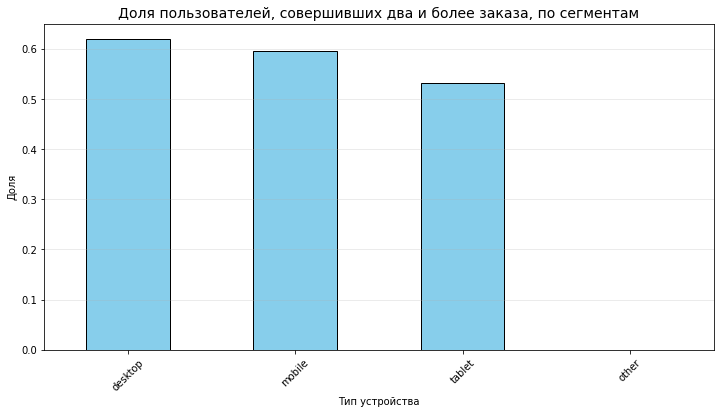

In [55]:
plt.figure(figsize=(12, 6))
part_device.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Доля пользователей, совершивших два и более заказа, по сегментам', fontsize=14)
plt.xlabel('Тип устройства')
plt.ylabel('Доля')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

Десктоп-пользователи - самые лояльные (62% возвращаются) - возможно, совершают более осознанные, запланированные покупки.

Рассчитаем долю вернувшихся пользователей в зависимости от типа первого мероприятия.

Это позволит понять, какие категории мероприятий не только привлекают новую аудиторию, но и лучше удерживают её.

In [56]:
part_event_type = (
    user_profile.groupby('first_event_type')['is_two'].mean().sort_values(ascending=False)
)
part_event_type

first_event_type
фильм       0.736842
выставки    0.628429
театр       0.621916
концерты    0.603233
стендап     0.598696
другое      0.577422
спорт       0.545806
ёлки        0.543478
Name: is_two, dtype: float64

Визуализируем:

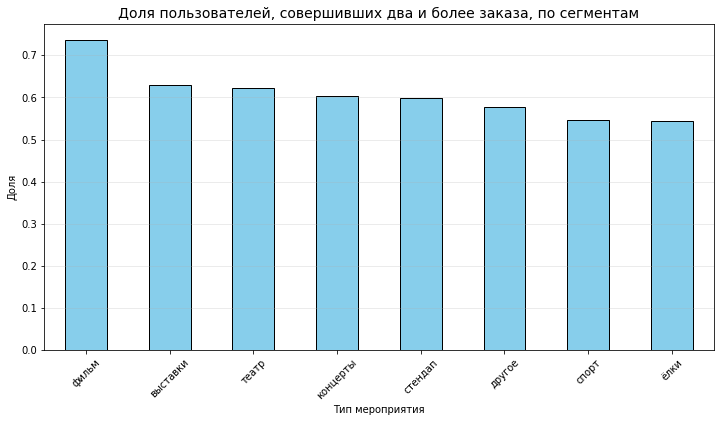

In [57]:
plt.figure(figsize=(12, 6))
part_event_type.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Доля пользователей, совершивших два и более заказа, по сегментам', fontsize=14)
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

Фильмы - абсолютный лидер по удержанию (74% возвращаются) - несмотря на минимальную долю как точки входа (0,09%), кинопоказы формируют самую лояльную аудиторию.

Рассчитаем долю вернувшихся пользователей в зависимости от региона первого заказа.

Это позволит выявить географические рынки с наибольшей лояльностью аудитории и понять, в каких регионах пользователи склонны к повторному взаимодействию.

In [58]:
part_region = (
    user_profile.groupby('first_region')['is_two'].mean().sort_values(ascending=False)
)
part_region

first_region
Верхозёрский край           1.000000
Озернопольская область      0.888889
Радужнопольский край        0.761905
Лесостепной край            0.696429
Лесноярский край            0.666667
                              ...   
Крутоводский регион         0.333333
Сосноводолинская область    0.000000
Светолесский край           0.000000
Островогорский округ        0.000000
Яснопольский округ          0.000000
Name: is_two, Length: 81, dtype: float64

Визуализируем:

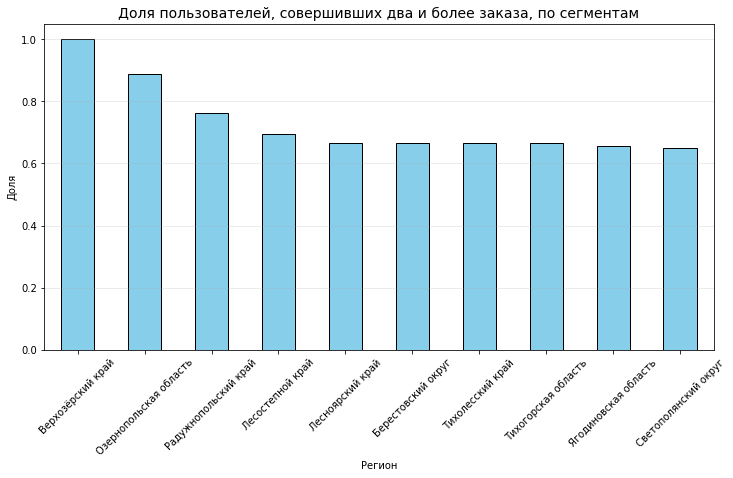

In [59]:
plt.figure(figsize=(12, 6))
part_region.head(10).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Доля пользователей, совершивших два и более заказа, по сегментам', fontsize=14)
plt.xlabel('Регион')
plt.ylabel('Доля')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

Регионы с экстремально высокой лояльностью (100%, 89%, 76%) имеют ничтожно малое количество пользователей - скорее всего, единичные случаи, поэтому эти значения статистически ненадёжны.

Проанализируем лояльность пользователей, пришедших от разных билетных операторов.

Рассчитаем долю вернувшихся пользователей для каждого оператора, чтобы оценить, какие партнёры способствуют формированию постоянной аудитории сервиса.

In [60]:
part_service_name = (
    user_profile.groupby('first_service_name')['is_two'].mean().sort_values(ascending=False)
)
part_service_name

first_service_name
Зе Бест!                  1.000000
Билет по телефону         0.833333
Быстрый кассир            0.830189
Реестр                    0.785714
Цвет и билет              0.687500
Восьмёрка                 0.678571
Crazy ticket!             0.666667
Show_ticket               0.644172
Край билетов              0.643498
Дом культуры              0.638484
Мир касс                  0.629442
Весь в билетах            0.613909
Выступления.ру            0.612903
Росбилет                  0.612245
Прачечная                 0.611111
Билеты в руки             0.609087
Облачко                   0.606473
Лови билет!               0.598322
Лучшие билеты             0.595837
Билеты без проблем        0.591172
Городской дом культуры    0.586854
Тебе билет!               0.584158
Быстробилет               0.583851
Мой билет                 0.579106
За билетом!               0.577889
Кино билет                0.545455
Яблоко                    0.524272
Лимоны                    0.500000
В

Визуализируем:

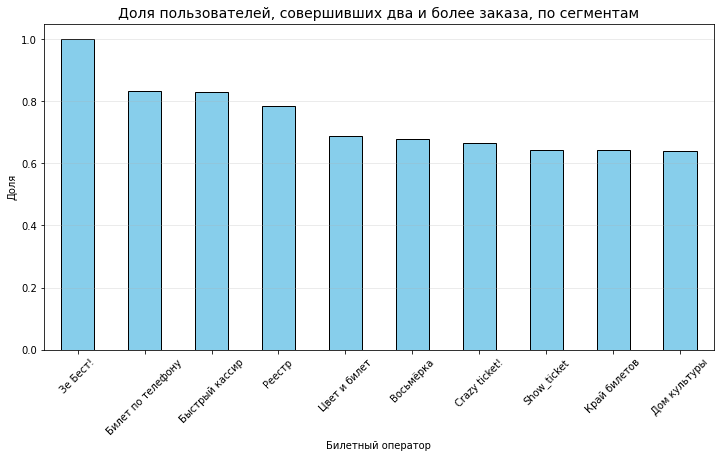

In [61]:
plt.figure(figsize=(12, 6))
part_service_name.head(10).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Доля пользователей, совершивших два и более заказа, по сегментам', fontsize=14)
plt.xlabel('Билетный оператор')
plt.ylabel('Доля')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

Лояльность пользователей почти не зависит от оператора — все крупные партнёры обеспечивают примерно одинаковый уровень удержания.

**Топ-сегменты с самой высокой лояльностью:**

По устройству: 
- Пользователи Desktop (ПК/ноутбуки) - 0.619.
Это самая лояльная аудитория. 

По типу мероприятия:
- Фильмы - 0.737 (абсолютный лидер). Это ключевая "точка входа".
- Выставки - 0.628 и Театр - 0.622. Также показывают высокую вовлеченность.

По региону:

- Верхозёрский край - 1.000 
- Озернопольская область - 0.889. Феноменально высокие показатели, но требуют осторожной интерпретации.

По билетному оператору:

- Зе Бест! - 1.000.
- Билет по телефону - 0.833.
- Быстрый кассир - 0.830.
- Реестр - 0.786.

Но некоторые аномально высокие значения вызваны малым размером выборки и являются нестабильными. Поэтому не стоит учитывать такие сигменты как регион Верхозёрский край, билетный оператор "Зе Бест!"

**Успешные точки входа** (сегменты с высокой конверсией в повторный заказ):
- Фильмы (0.737): Это самая сильная точка входа. Человек, впервые пришедший купить билет в кино, с максимальной вероятностью вернется на Яндекс Афишу снова. Это может быть связано с низким порогом входа, частотой события и, возможно, удобством сервиса именно для этого типа покупок.

- Desktop-аудитория (0.619): Первый заказ с компьютера - хороший индикатор будущей лояльности. Это говорит о том, что "осознанные" покупки с большим экрана, возможно, связанные с планированием досуга, создают более прочную связь с сервисом.

- Выставки и Театр (~0.625): Также являются отличными точками входа. Пользователи, заинтересованные в этих культурных мероприятиях, высоко ценят сервис и возвращаются.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

**Проверим первую гипотезу основываясь на анализе, проведённом выше:**

Пользователи, впервые купившие билеты на концерты(60.3%), возвращаются на Яндекс Афишу чаще, чем те, чей первый заказ был на спортивные мероприятия(54.6%). Разница в конверсии составляет около +5.7% в пользу концертов, поэтому `Гипотеза 1` отвергнута.

**Теперь проверим вторую гипотезу:**

В самых активных регионах (Каменевский, Североярская область) доля повторных заказов - средняя. Они не лидируют по лояльности.

Кажущиеся лидеры по лояльности (Верхозёрский край и др.) имеют ничтожно малую пользовательскую базу. Их экстремально высокие показатели (100%, 88%) являются статистическим шумом и не отражают реальной закономерности.

Для принятия решений нужно сфокусироваться на лояльности в крупных, стабильных регионах. В них, судя по всему, доля повторных заказов различается незначительно. 

Следовательно `Гипотеза 2` отвергнута. Не существует прямой положительной связи между размером пользовательской базы региона и долей повторных заказов.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


Проверить гипотезу, что лояльные пользователи (2+ заказа) в среднем совершают более дорогие покупки, чем разовые клиенты.

Создадим бинарный столбец `is_one`, который отмечает пользователей, совершивших ровно один заказ.

In [62]:
user_profile['is_one'] = (user_profile['order_count'] == 1).astype(int)

Создадим две выборки:

`one_order_revenue` — пользователи, совершившие ровно 1 заказ

`returned_revenue` — пользователи, совершившие 2 и более заказов

In [63]:
one_order_revenue = user_profile[user_profile['is_one'] == 1]['avg_revenue']
returned_revenue = user_profile[user_profile['is_two'] == 1]['avg_revenue']

Построим две наложенные гистограммы с нормализацией (density=True), чтобы сравнивать формы распределений независимо от размера групп.

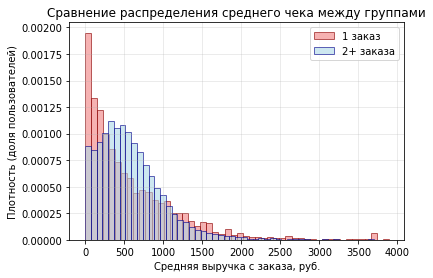

In [64]:
plt.hist(one_order_revenue, bins=50, alpha=0.6, label='1 заказ', 
         color='lightcoral', edgecolor='darkred', density=True)
plt.hist(returned_revenue, bins=50, alpha=0.6, label='2+ заказа', 
         color='lightblue', edgecolor='darkblue', density=True)

plt.title('Сравнение распределения среднего чека между группами')
plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность (доля пользователей)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**Группа "1 заказ" (красная):**
Основной пик: 0-500 рублей

**Группа "2+ заказа" (синяя):**
Основной пик: 0-500 рублей (тоже высокий, но ниже чем у "1 заказа")

**Различия:**
- Те, кто купил один раз, в основном берут дешёвые билеты (0–500 рублей) - это их основная ценовая категория.

- Те, кто вернулся, тоже часто покупают дёшево, но значительно чаще выбирают билеты от 500 до 2500 рублей. 

То есть вернувшиеся покупатели готовы больше тратить и покупать билеты разной ценовой категории.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


Проверим отличаются ли самые лояльные пользователи (5+ заказов) по среднему чеку от умеренно лояльных (2-4 заказа).

Создадим сегмент `2-4 заказа`:

In [65]:
user_profile['is_2_to_4'] = ((user_profile['is_two'] == 1) & (user_profile['is_five'] == 0)).astype(int)

Выделим две групп для сравнения:

In [66]:
group_2_4 = user_profile[user_profile['is_2_to_4'] == 1]['avg_revenue']
group_5 = user_profile[user_profile['is_five'] == 1]['avg_revenue']

Построим сравнительные гистограммы:

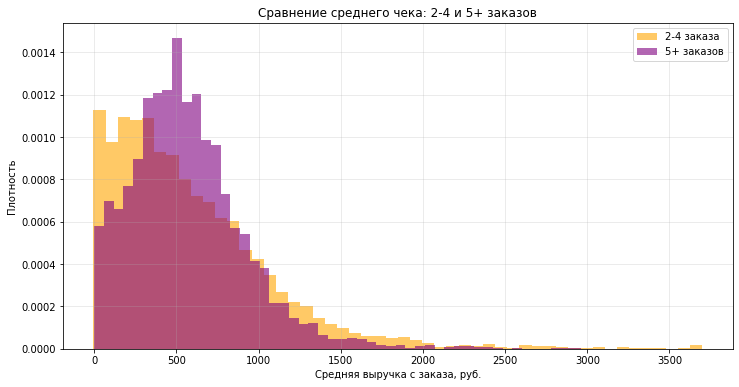

In [67]:
plt.figure(figsize=(12, 6))
plt.hist(group_2_4, bins=50, alpha=0.6, label='2-4 заказа', 
         color='orange', density=True)
plt.hist(group_5, bins=50, alpha=0.6, label='5+ заказов', 
         color='purple', density=True)
plt.title('Сравнение среднего чека: 2-4 и 5+ заказов')
plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Пользователи "5+ заказов" (самые лояльные) реже покупают самые дешёвые билеты (0-500 руб.) и чаще выбирают билеты в среднем ценовом диапазоне.

Пользователи "2-4 заказа" (умеренно лояльные) часто начинают с дешёвых покупок, и только часть из них переходит к более дорогим билетам.

**Рекомендации:** Чтобы перевести пользователя из группы "2-4 заказа" в группу "5+ заказов", нужно стимулировать покупки в среднем ценовом сегменте, а не только дешёвые билеты.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам - равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?


Проводём анализ лояльности пользователей в зависимости от среднего количества билетов в их заказах.

Создадим сегменты по количеству билетов:

In [68]:
user_profile['segment_tickets_count'] = pd.cut(user_profile['avg_tickets_count'], 
                                               bins=[0, 2, 3, 5, 100], 
                                               labels=["1-2 билета", "2-3 билета", "3-5 билета", "5+ билета"])

Агрегируем данные по сегментам и сортируем по доле повторных заказов:

In [69]:
result_tickets_count = (
    user_profile.groupby('segment_tickets_count').agg(
        count_users=('segment_tickets_count', 'size'),
        repeat_users=('is_two', 'sum')
    ).reset_index()
)
result_tickets_count['repeat_share'] = result_tickets_count['repeat_users'] / result_tickets_count['count_users']
result_tickets_count.sort_values(by='repeat_share', ascending=False)

,segment_tickets_count,count_users,repeat_users,repeat_share
1,2-3 билета,9070,6568,0.724146
2,3-5 билета,5308,3308,0.623210
0,1-2 билета,6188,2485,0.401584
3,5+ билета,206,69,0.334951


Распределение сконцентрировано в сегментах `2-3 билета`, `3-5 билета`, `1-2 билета`. 

В сегменте `5+ билетов` всего 206 пользователей - это очень маленькая группа и  самая низкая лояльность (скорее всего, разовые групповые заказы).

Пользователи, покупающие `2-3 билета` - ключевой сегмент, ведь он самый многочисленный и у него самая большая лояльность. 

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


Проанализируем, как день недели первого заказа связан с лояльностью пользователей.

Извлечём дня недели из даты первого заказа в столбец `day_of_week`:

In [70]:
user_profile['day_of_week'] = user_profile['first_dt'].dt.dayofweek

Агрегируем данные по дням недели:

- `count_users` - сколько пользователей совершили первый заказ в каждый день недели

- `repeat_users` — сколько из них вернулись (совершили 2+ заказа)

- `repeat_share` — доля вернувшихся для каждого дня

In [71]:
result_week = user_profile.groupby('day_of_week').agg(
    count_users=('day_of_week', 'size'),
    repeat_users=('is_two', 'sum')
)
result_week['repeat_share'] = result_week['repeat_users'] / result_week['count_users']
result_week.sort_values(by='repeat_users', ascending=False)

,count_users,repeat_users,repeat_share
day_of_week,,,
5,3142,1900,0.604710
4,3197,1892,0.591805
2,2959,1797,0.607300
3,3033,1782,0.587537
1,2972,1779,0.598587
0,2798,1727,0.617227
6,2671,1553,0.581430


Построим столбчатую диаграмму по дням недели и количеству пользователей, совершивших повторные заказы:

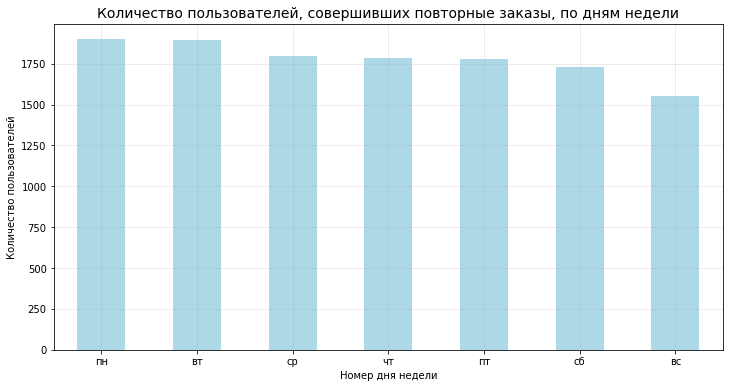

In [72]:
result_week.sort_values('repeat_users', ascending=False)['repeat_users'].plot(
    kind='bar', 
    figsize=(12, 6),
    color=['lightblue']
)
plt.title('Количество пользователей, совершивших повторные заказы, по дням недели', fontsize=14)
plt.xlabel('Номер дня недели')
plt.ylabel('Количество пользователей')
days_names = ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс']
plt.xticks(range(len(days_names)), days_names, rotation=0)
plt.grid(alpha=0.3)
plt.show()

Все дни показывают стабильно высокую возвращаемость (58–62%), поэтому день недели первого заказа не является критическим фактором для лояльности.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


Проанализируем средний интервал между заказами для двух групп пользователей `совершившие 2-4 заказа` и `совершившие 5 и более заказов`.

Рассчитаем средний интервал у первой группы:

In [73]:
grouped_interval = user_profile.groupby('is_2_to_4')['avg_between_days'].mean()
grouped_interval 

is_2_to_4
0    11.410563
1    21.395763
Name: avg_between_days, dtype: float64

Рассчитаем средний интервал у второй группы:

In [74]:
grouped_interval = user_profile.groupby('is_five')['avg_between_days'].mean()
grouped_interval 

is_five
0    21.522909
1    11.141160
Name: avg_between_days, dtype: float64

Клиенты с 2-4 заказами обращаются к сервису эпизодически, в среднем раз в три недели.

Клиенты с 5+ заказами демонстрируют устойчивую привычку: они совершают покупки примерно вдвое чаще - раз в полторы недели.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

Проведём корреляционный анализ между сегментом пользователя по количеству заказов и другими характеристиками его профиля.

Создадим сегменты по количеству заказов:

In [75]:
user_profile['segment_order_count'] = pd.cut(user_profile['order_count'], 
                                               bins=[0, 1, 4, 100], 
                                               labels=["1 заказ", "2-4 заказов", "5+ заказов"])

Расчитаем матрицу корреляции phi_k:

In [76]:
correlation_matrix = user_profile[['avg_revenue', 'avg_tickets_count', 
                                   'avg_between_days', 'first_region',
                                   'first_device_type', 'first_service_name',
                                   'first_event_type', 'segment_tickets_count', 
                                   'day_of_week', 'segment_order_count']].phik_matrix()

# Выделяем корреляции с total_orders
correlations_with_orders = correlation_matrix.loc[
    correlation_matrix.index != 'segment_order_count'
][['segment_order_count']].sort_values(by='segment_order_count', ascending=False)
correlations_with_orders

interval columns not set, guessing: ['avg_revenue', 'avg_tickets_count', 'avg_between_days', 'day_of_week']


,segment_order_count
avg_between_days,0.387346
avg_tickets_count,0.355372
avg_revenue,0.270448
segment_tickets_count,0.237397
first_region,0.106451
first_service_name,0.074817
first_event_type,0.044238
first_device_type,0.015354
day_of_week,0.014830


Визуализируем результат корреляции с помощью тепловой карты и библиотеки seaborn:

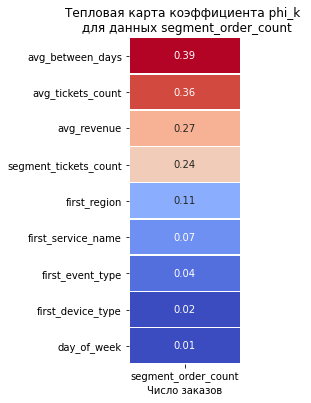

In [77]:
# Строим тепловую карту
plt.figure(figsize=(2, 6))

# Сохраняем матрицу корреляции признака segment_order_count с другими признаками пользователя
data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'segment_order_count'][['segment_order_count']].sort_values(by='segment_order_count', ascending=False)
sns.heatmap(data_heatmap,
            annot=True, # Отображаем численные значения в ячейках карты
            fmt='.2f', # Форматируем значения корреляции: два знака после точки
            cmap='coolwarm', # Устанавливаем цветовую гамму от красного (макс. значение) к синему
            linewidths=0.5, # Форматируем линию между ячейками карты
            cbar=False # Отключаем цветовую шкалу
           )

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k \n для данных segment_order_count')
plt.xlabel('Число заказов')

# Выводим график
plt.show()

Наиболее сильную связь с количеством заказов имеют поведенческие паттерны пользователей:

- Частота покупок (`avg_between_days` - 0.389) - чем быстрее пользователь возвращается, тем выше его лояльность.

- Размер заказа (`avg_tickets_count` - 0.355) - покупка нескольких билетов сразу коррелирует с большим числом заказов.

- Средний чек (`avg_revenue` - 0.270) - более дорогие покупки также связаны с повторными визитами.

День недели, тип устройства, первое мероприятие практически не влияют на лояльность - их корреляции близки к нулю.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

В ходе исследования проанализированы данные 292 034 транзакций и созданы профили 21837 пользователей Яндекс Афиши. Выручка конвертирована в рубли, исключены статистические выбросы (0,05% данных)."

Выделим ключевые аспекты анализа:

- Распределение по количеству заказов резко асимметрично: большинство пользователей совершили только 1 заказ.

- Ключевые статистические показатели
  - Распределение по устройствам: Мобильные устройства - абсолютный лидер (82,7% первых заказов)
  - Распределение по мероприятиям: Концерты - основная категория (43,5%)
  - Концентрация по регионам: Каменевский регион доминирует (33,1%)
  - Лояльность: Средняя доля возврата - 58-62% в зависимости от сегмента

- Признаки первого заказа, связанные с возвратом
  - Тип мероприятия: Фильмы (73,7% возврата), выставки (62,8%), театр (62,2%)
  - Устройство: Десктопы (61,9%) vs мобильные (59,5%)
  - Не влияют: День недели, конкретный билетный оператор, тип устройства

- Влияние финансовых показателей на лояльность
  - Средний чек: Вернувшиеся пользователи чаще покупают в диапазоне 500-2500 рублей, а не только самые дешёвые билеты (0-500 руб.)
  - Количество билетов: Пользователи, покупающие 2-3 билета, показывают максимальную лояльность (72,4%)

- Временные характеристики
  - День недели: Не имеет значимого влияния 
  - Интервалы между покупками: Ключевой фактор! Пользователи с 5+ заказами покупают в 2 раза чаще

- Согласно корреляционному анализу, наибольшую связь с количеством заказов имеют:
  - Частота покупок (0,389) - самый важный фактор
  - Количество билетов в заказе (0,355)
  - Средний чек (0,270)

- Самые массовые точки входа (мобильные, концерты) не дают максимальной лояльности

- Пользователи, покупающие 2-3 билета — идеальный сегмент: и многочисленные (41,5%), и самые лояльные (72,4%)

**Рекомендации:**
- Для пользователей с чеками меньше 500 рублей - предложить более дорогие мероприятия при следующем посещении
- Стимулировать переход из "1-2 билета" в "2-3 билета":
    - "Приведи друга" - скидка на второй/третий билет
    - "Семейный абонемент" - выгоднее покупать 2-3 билета сразу
- Усилить работу с десктоп-аудиторией - менее массовая, но более лояльная

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**